In [1]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries
from torchtext.legacy.data import Field, TabularDataset, BucketIterator

# Models

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Tools
from sklearn.model_selection import train_test_split


# Phishing  => 1
# Non-Phishing  => 0

In [2]:
print(torch.torch.__version__)


1.8.1


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
df_train_full = pd.read_csv("../input/CSV/Train.csv")
df_test = pd.read_csv("../input/CSV/Test.csv")
df_train, df_valid = train_test_split(df_train_full, train_size=0.90, random_state=7) 

In [5]:
df_test = pd.read_csv("ttv_csvs/test.csv")
df_train = pd.read_csv("ttv_csvs/train.csv")
df_valid = pd.read_csv("ttv_csvs/valid.csv")

In [6]:
df_test = df_test.dropna().reset_index(drop=True)
df_train = df_train.dropna().reset_index(drop=True)
df_valid = df_valid.dropna().reset_index(drop=True)

In [7]:
df_train.isna().sum()

Phishing    0
Text        0
dtype: int64

In [8]:
df_train

,Phishing,Text
0,0,chris foster checked couldnt find anything reg...
1,1,desk dr frank west director incharge auditing ...
2,1,eddie started slowly toward feet gritting plas...
3,1,desk mr williams padmoreauditor general intern...
4,0,wanted let know havent forgotten traders sched...
...,...,...
9748,1,mr cheung puihang seng bank ltd des voeux rd b...
9749,1,help deskthis email sent outlook web app agree...
9750,1,hours left update email account please find at...
9751,0,p forwarded elizabeth sager hou ect pm enron n...


In [9]:
source_folder = "./ttv_csvs"

# Write split data
df_train.to_csv(source_folder + '/train.csv', index=False)
df_valid.to_csv(source_folder + '/valid.csv', index=False)
df_test.to_csv(source_folder + '/test.csv', index=False)

In [10]:
df_train.isna().sum()

Phishing    0
Text        0
dtype: int64

In [11]:
import spacy
spacy.load('en_core_web_sm')


In [12]:

# Fields
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
fields = [("Phishing", label_field), ('Text', text_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv', test='test.csv', format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.Text), device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.Text), device=device, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.Text), device=device, sort=True, sort_within_batch=True)

# Vocabulary

text_field.build_vocab(train, min_freq=3)

In [13]:
class LSTM(nn.Module):

    def __init__(self, dimension=128):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(2*dimension, 1)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out

In [14]:
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [15]:
destination_folder = "./outputs"

# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, (Text, Text_len)), _ in train_loader:           
            labels = labels.to(device)
            Text = Text.to(device)
            Text_len = Text_len.to(device)
            output = model(Text, Text_len)

            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for (labels, (Text, Text_len)), _ in valid_loader:
                      labels = labels.to(device)
                      Text = Text.to(device)
                      Text_len = Text_len.to(device)
                      output = model(Text, Text_len)

                      loss = criterion(output, labels)
                      valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [16]:
model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
train(model=model, optimizer=optimizer, num_epochs=10)

Epoch [1/10], Step [152/3050], Train Loss: 0.0704, Valid Loss: 0.1617
Model saved to ==> ./outputs/model.pt
Model saved to ==> ./outputs/metrics.pt
Epoch [1/10], Step [304/3050], Train Loss: 0.0389, Valid Loss: 0.0943
Model saved to ==> ./outputs/model.pt
Model saved to ==> ./outputs/metrics.pt
Epoch [2/10], Step [456/3050], Train Loss: 0.0431, Valid Loss: 0.1054
Epoch [2/10], Step [608/3050], Train Loss: 0.0202, Valid Loss: 0.0593
Model saved to ==> ./outputs/model.pt
Model saved to ==> ./outputs/metrics.pt
Epoch [3/10], Step [760/3050], Train Loss: 0.0206, Valid Loss: 0.0466
Model saved to ==> ./outputs/model.pt
Model saved to ==> ./outputs/metrics.pt
Epoch [3/10], Step [912/3050], Train Loss: 0.0029, Valid Loss: 0.0421
Model saved to ==> ./outputs/model.pt
Model saved to ==> ./outputs/metrics.pt
Epoch [4/10], Step [1064/3050], Train Loss: 0.0085, Valid Loss: 0.0466
Epoch [4/10], Step [1216/3050], Train Loss: 0.0006, Valid Loss: 0.0411
Model saved to ==> ./outputs/model.pt
Model save

Model loaded from <== ./outputs/metrics.pt


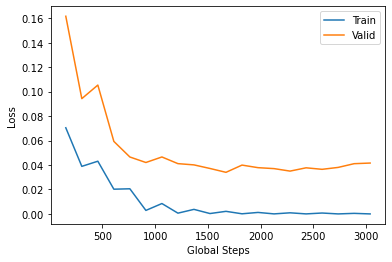

In [20]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [21]:
# Evaluation Function

def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, (Text, Text_len)), _ in test_loader:           
            labels = labels.to(device)
            Text = Text.to(device)
            Text_len = Text_len.to(device)
            output = model(Text, Text_len)

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['PHISH', 'NORMAL'])
    ax.yaxis.set_ticklabels(['PHISH', 'NORMAL'])

Model loaded from <== ./outputs/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.9825    0.9883    0.9854      1367
           0     0.9880    0.9821    0.9851      1342

    accuracy                         0.9852      2709
   macro avg     0.9853    0.9852    0.9852      2709
weighted avg     0.9853    0.9852    0.9852      2709



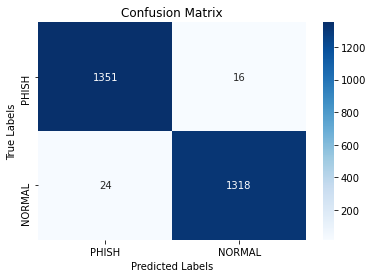

In [22]:
best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)

In [ ]:
df_valid[sentence for sentence in df_valid if len(sentence) < 10]

SyntaxError: invalid syntax (<ipython-input-84-25c722a77d9a>, line 1)

In [ ]:
df_valid

,Phishing,Text
0,1,dear sir madam letter may come surprise due fa...
1,0,extended deal mtr include future please run we...
2,1,deari know proposal might surprise consider em...
3,1,dr tony devon road isieke close sungu johannes...
4,0,andy please assign user name randy gay thank p...
...,...,...
1079,0,get chance id like talk mm position thanksd
1080,1,dearerst make appeal understanding facts opini...
1081,0,appears missed cpys referenced list tom freeze...
1082,1,ebay sent message behalf cellunex registered n...
